# Chapter.9.01 SVLoR for One Sample

SVLoR을 One sample을 통해서 진행하여<br>
decision boundary가 어떻게 형성되는지 확인한다

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import basic_nodes as nodes

### Step.1
먼저 데이터 생성을 위하여 dataset_generator함수를 구현한다<br>
input으로 mean, std, n_sample, noise_factor, cutoff, direction,이 포함된<br>
x_dict를 받는다

In [17]:
def dataset_generator(x_dict):
    ### Start
    x_data = np.random.normal(x_dict['mean'], x_dict['std'],x_dict['n_sample'])
    x_data_noise = x_data + x_dict['noise_factor'] * np.random.normal(0,1,x_dict['n_sample'])
    if x_dict['direction'] > 0:
        y_data = (x_data_noise > x_dict['cutoff']).astype(np.int)
    else:
        y_data = (x_data_noise < x_dict['cutoff']).astype(np.int)
    
    data = np.zeros(shape = (x_dict['n_sample'],1))
    data = np.hstack((data,x_data.reshape(-1,1),y_data.reshape(-1,1)))
    ### End
    return data

### Step.2
dataset_generator을 통하여 Dataset을 생성하는데<br><br>
"""<br>
mean: 1<br>
std: 1<br>
n_sample: 300<br>
noise_factor: 0.3<br>
cutoff: 1<br>
direction: 1<br>
"""<br><br>
위와 같이 x_dict를 생성하여 dataset_generator를 실행한다

In [18]:
x_dict = {'mean':1,
          'std':1,
          'n_sample':300,
          'noise_factor':0.3,
          'cutoff':1,
          'direction':1}
data = dataset_generator(x_dict)

### Step.3
먼저 mul_node와 plus_node를 선언합니다<br>
그리고 필요한 변수들을 정의합니다<br>
iter_idx는 0으로 초기화하고 확인을 위해 사용할 check_freq는 5마다 체크합니다<br>
epoch는 100으로 설정하고 lr은 0.1로 설정합니다

In [19]:
node1 = nodes.mul_node()
node2 = nodes.plus_node()
### Start
Th = np.array([5., 5.]).reshape(-1,1)
th_accum = Th

loss_list = []
iter_idx, check_freq = 0, 5
epochs, lr = 100, 0.1
### End

### Step.4 Training

In [20]:
for epoch in range(epochs):
    np.random.shuffle(data)
    
    for data_idx in range(data.shape[0]):
        ### Start
        x,y = data[data_idx,1], data[data_idx,-1]
        
        z1 = node1.forward(Th[1],x)
        z2 = node2.forward(Th[0],z1)
        pred = 1/(1 + np.exp(-1*z2))
        
        loss = -1*(y*np.log(pred) + (1-y)*np.log(1 - pred))
        
        dpred = (pred - y) / (pred * (1 - pred))
        dz2 = dpred * (pred*(1-pred))
        dth0, dz1 = node2.backward(dz2)
        dth1, dx = node1.backward(dz1)
        
        Th[1] = Th[1] - lr*dth1
        Th[0] = Th[0] - lr*dth0
        ### End
        
        if iter_idx % check_freq == 0:
            th_accum = np.hstack((th_accum, Th))
            loss_list.append(loss)
        iter_idx += 1

### Step.5 Visualization

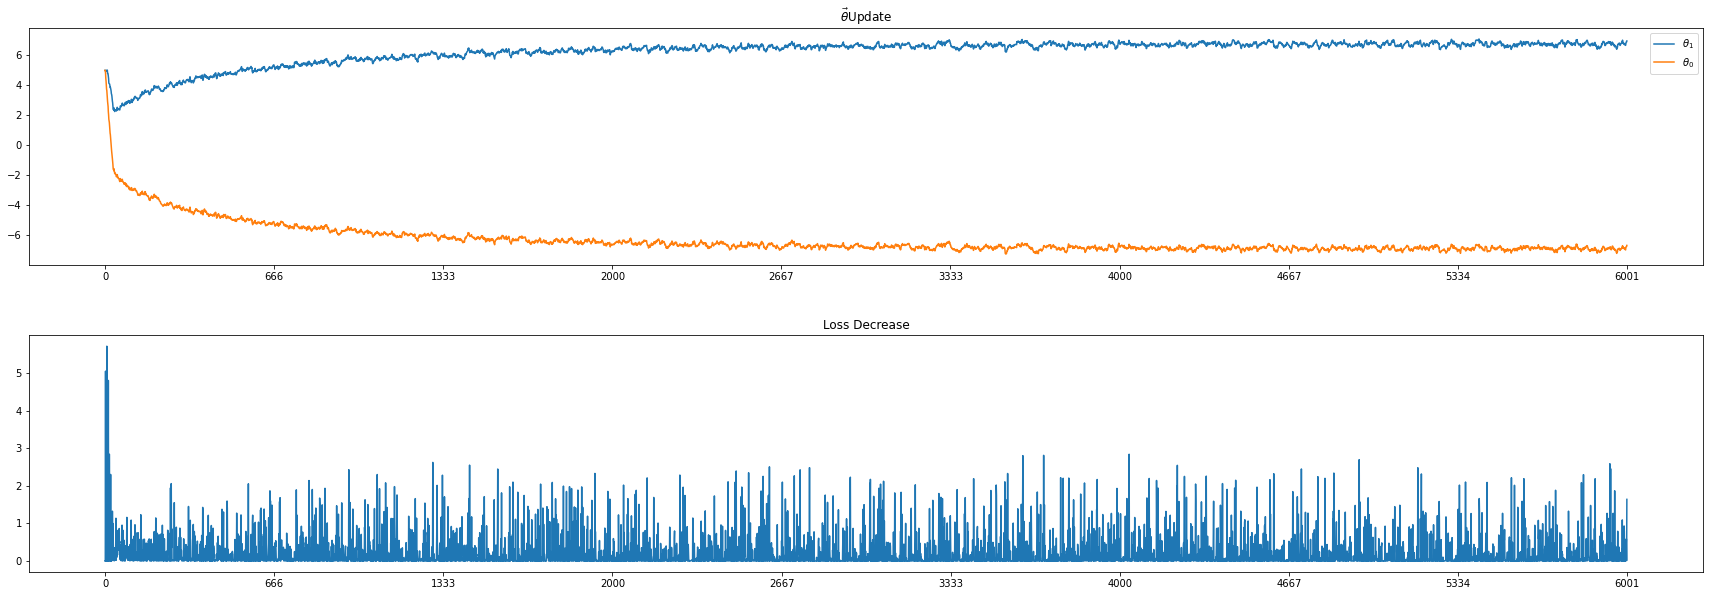

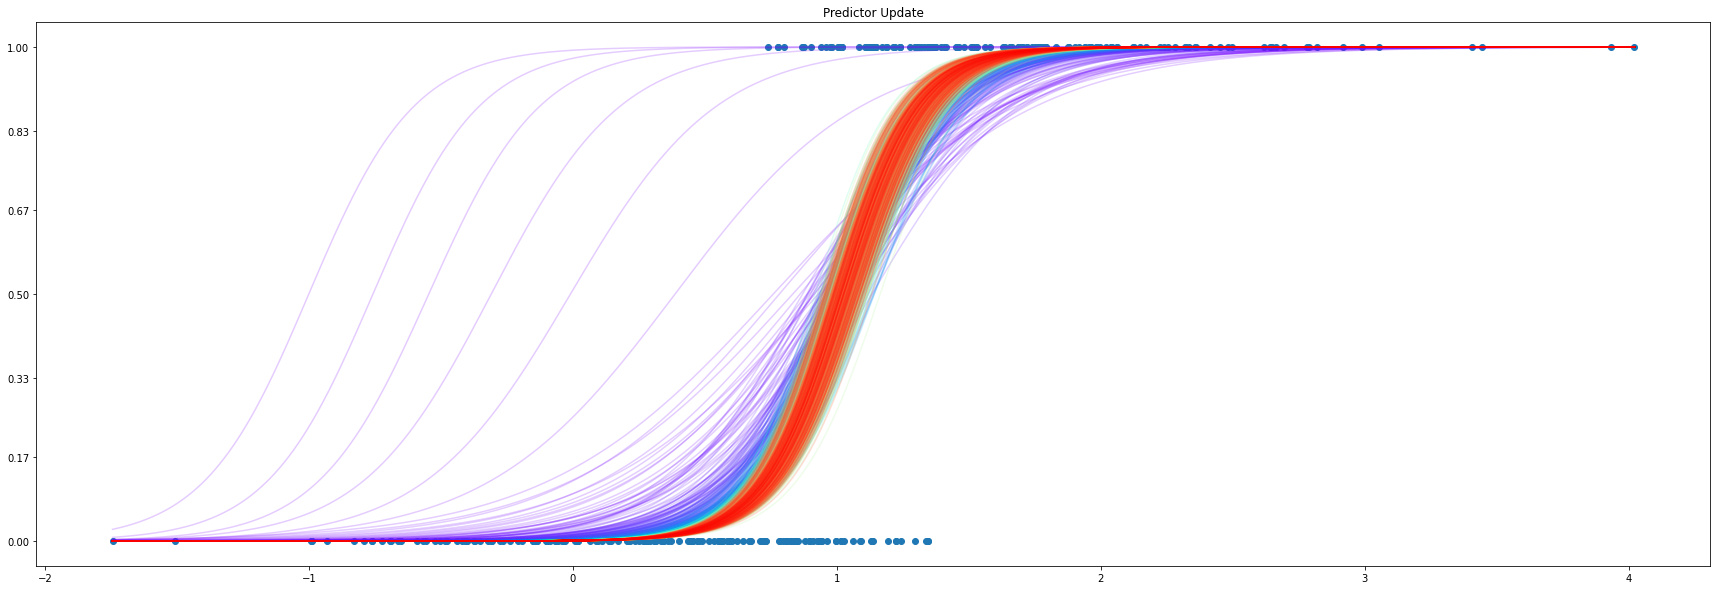

In [21]:
fig, ax = plt.subplots(2,1, figsize = (30,10))
fig.subplots_adjust(hspace = 0.3)
ax[0].set_title(r'$\vec{\theta}$' + 'Update')

ax[0].plot(th_accum[1,:], label = r'$\theta_{1}$')
ax[0].plot(th_accum[0,:], label = r'$\theta_{0}$')

ax[0].legend()
iter_ticks = np.linspace(0, th_accum.shape[1],10).astype(np.int)
ax[0].set_xticks(iter_ticks)

ax[1].set_title('Loss Decrease')
ax[1].plot(loss_list)
ax[1].set_xticks(iter_ticks)

n_pred = 1000
fig,ax = plt.subplots(figsize = (30,10))
ax.set_title('Predictor Update')
ax.scatter(data[:,1],data[:,-1])

ax_idx_arr = np.linspace(0, len(loss_list)-1, n_pred).astype(np.int)
cmap = cm.get_cmap('rainbow',lut = len(ax_idx_arr))

x_pred = np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000)

for ax_cnt,ax_idx in enumerate(ax_idx_arr):
    z = th_accum[1, ax_idx]*x_pred + th_accum[0, ax_idx]
    a = 1/(1 + np.exp(-1*z))
    ax.plot(x_pred,a,color = cmap(ax_cnt),alpha = 0.2)
y_ticks = np.round(np.linspace(0,1,7),2)
ax.set_yticks(y_ticks)